In [1]:
import cPickle
import numpy as np
import graphlab as gl
import matplotlib.pyplot as plt
from IPython.display import display, Image
from scipy import ndimage

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
with open("F:\DataAnalysis&MachineLearning\ResearchAttempt\WorkWithIan\Dataset\mnist.pkl",'rb') as mnist_file:
    train_data,valid_data,test_data = cPickle.load(mnist_file)

9


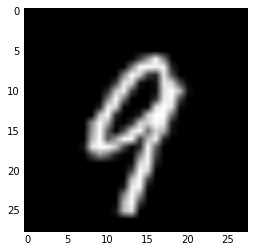

In [3]:
## In this block we are shuffling the data to avoid any classification bias
train_vec_in,train_label_out = train_data
permutation = np.random.permutation(train_vec_in.shape[0])
train_vec_in = train_vec_in[permutation,:]
train_reshape = np.reshape(train_vec_in,newshape=[50000,28,28])
train_label_out = train_label_out[permutation]

plt.imshow(train_reshape[3],cmap='gray')
print train_label_out[3]

In [4]:
valid_features,valid_labels = valid_data
test_features,test_labels = test_data

## Building on logistic regression

The link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will be using numpy arrrays and operations for implementation

In [36]:
'''Converting graphlab sframe to numpy. 
This is not required here since the data is already numpy.ndarray'''

def get_numpy_data(data_sframe, features, label):
    if 'intercept' not in data_sframe.column_names():
        data_sframe['intercept'] = 1
        features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [37]:
def prediction_probability(features,coefficients):
    score = np.dot(features,coefficients)
    probability = 1./(1+ np.exp(-score))
    return probability

In [38]:
import math
def log_likelihood(features,coefficients,sentiments):
    indicator = (sentiments==+1)
    score = np.dot(features,coefficients)
    logexp = np.log(1 + np.exp(-score))
    likelihood = np.sum((indicator-1)*score - logexp)
    return likelihood

def derivative_likelihood(errors, feature):     
    # Compute the dot product of errors and feature
    derivative = np.dot(feature, errors)
    
    # Return the derivative
    return derivative

In [39]:
def logistic_regression(feature_matrix, sentiment, initial_coefficients, step_size, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):

        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # YOUR CODE HERE
        predictions = prediction_probability(feature_matrix, coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in xrange(len(coefficients)): # loop over each coefficient
            
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            # YOUR CODE HERE
            derivative = derivative_likelihood(errors, feature_matrix[:,j])
            
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] = coefficients[j] + step_size*derivative
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = log_likelihood(feature_matrix, coefficients, sentiment)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

In [ ]:
coefficients = logistic_regression(train_vec_in, train_label_out, initial_coefficients=np.zeros(194),
                                   step_size=1e-7, max_iter=301)

## Multinomial Regression
Here we have a multiclass Regression problem, which cannot be solved by Logistic Regression. We will be using Softmax Regression.
http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/



In [5]:
def softmax_probability(coefficients,features):
    if np.shape(coefficients)[1] != np.shape(features)[0]:
        coefficients = np.transpose(coefficients)
    score = np.dot(coefficients,features)
    return np.transpose(np.exp(score-np.amax(score,axis=0))/np.sum(np.exp(score-np.amax(score,axis=0)),axis=0))
    #'''subtracting score by max(score,axis=0) for maintaining numerial stability'''
    #return np.exp(score-max(score))/np.sum(np.exp(score-max(score)),axis=0)

In [8]:
test_x = np.array([[1,2,3,4],[4,5,6,7],[7,7,9,10]])
test_y = np.array([[1,2],[2,1],[1,4]])
print softmax_probability(test_x,test_y)

[[  6.03293373e-06   1.21174713e-04   1.79839220e-02   9.81888870e-01]
 [  7.57565221e-10   1.52161042e-08   9.11051180e-04   9.99088933e-01]]


In [9]:
#Test Vectors
coefficients = np.array([[1, 2, 3, 6],
                   [2, 4, 5, 6],
                   [3, 8, 7, 6]])
x = np.array([0.5,0.5,0.5])
print np.shape(x)
score = np.dot(coefficients.T,x)
print softmax_probability(coefficients,x)

(3L,)
[ 0.00182135  0.0994422   0.16395247  0.73478399]


In [6]:
## One hot encoding
# output_label - Numpy Array (1-D)
# classes - all possible output classes
def one_hot_encoding(output_label,classes):
    '''It is highly probable that our output_label array consists of all possible classes.
    Yet we will be using num_classes to be sent from outside.'''
    output_dim = np.shape(output_label)
    one_hot_encoded = np.zeros(shape=(output_dim[0],np.shape(classes)[0]))
    for i in xrange(output_dim[0]):
        ind = np.where(classes == output_label[i])[0][0]
        one_hot_encoded[i][ind] = 1
    
    ## The following will work only when output_label consists of numbers and is valued from 0
    #one_hot_encoded[np.arange(output_dim[0]),output_label] = 1        
        
    return one_hot_encoded

In [179]:
# Test Vectors
label = np.array([2,1,4,3,6,6])
classes = np.array([1,2,3,4,5,6])
print one_hot_encoding(label,classes)

[[ 0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.]]


In [7]:
## Coefficients = (num_classes,num_types_features)
#  features = (num_datapoints,num_types_features)
def softmax_regression(coefficients,features_set,output_label,classes,step_size,lamda,max_iter=1000,fit_intercept=True):   
    features= features_set
    if fit_intercept:
        features = np.concatenate((np.ones((np.shape(features)[0])),features),axis=1)
        coefficients = np.concatenate((np.zeros((np.shape(features)[0])),coefficients),axis=1)
    
    features_dim = np.shape(features)
    coeff_dim = np.shape(coefficients)
    probs = np.zeros(shape=(coeff_dim[1],features_dim[0]))
    cost = []
    
    for count in xrange(max_iter): 
        # Probability is of the shape = [number of datapoints, number of classes]
        probs = softmax_probability(coefficients,features.T)
        
        # For l2 regularization we will not take the sum of intercept coefficients.
        data_loss = -np.sum(np.log(probs[range(features_dim[0]),output_label])) + lamda*np.sum((coefficients*coefficients)[1:])
        cost.append(data_loss) #/features_dim[0])

        ''' Computing the gradient. 
        Shape of Features(X) = [Number of data points, number of features].
        Shape of Probabilities = [number of data points, number of classes].
        Here we will have to compute the outer product of X & Probabilities. Each column will then correspond to 
        the cost derivative w.r.t to corresponding class'''
        probs[range(features_dim[0]),output_label] -= 1
        derivative = np.dot(features.T,probs) + 2*lamda*coefficients.T
        coefficients = coefficients - step_size*(derivative.T + 2*lamda*coefficients)
        '''if fit_intercept:
            coefficients[:,0] = coefficients[:,0] - step_size*derivative[0,:]
            coefficients[:,1:] = coefficients[:,1:] - step_size*(derivative[1:,:].T + 2*lamda*coefficients[:,1:])
        else:
            coefficients = coefficients - step_size*(derivative.T + 2*lamda*coefficients)'''
            
    if fit_intercept:
        return coefficients[:,1:]
    else:
        return coefficients,cost
    return coefficients,cost

In [8]:
## Coefficients = (num_classes,num_types_features)
#  features = (num_datapoints,num_types_features)
def softmax_regression_with_feature_scaling(coefficients,features_set,output_label,classes,step_size,lamda, \
                                            max_iter=1000,fit_intercept=True):  
    ''' Feature Scaling '''
    features = (features_set-np.mean(features_set,axis=0))/np.std(features_set,axis=0)
    
    if fit_intercept:
        features = np.concatenate((np.ones((np.shape(features)[0])),features),axis=1)
        coefficients = np.concatenate((np.zeros((np.shape(features)[0])),coefficients),axis=1)
    
    features_dim = np.shape(features)
    coeff_dim = np.shape(coefficients)
    probs = np.zeros(shape=(coeff_dim[1],features_dim[0]))
    cost = []
    
    for count in xrange(max_iter): 
        # Probability is of the shape = [number of datapoints, number of classes]
        probs = softmax_probability(coefficients,features.T)
        
        # For l2 regularization we will not take the sum of intercept coefficients.
        data_loss = -np.sum(np.log(probs[range(features_dim[0]),output_label])) + lamda*np.sum((coefficients*coefficients)[1:])
        cost.append(data_loss) #/features_dim[0])

        ''' Computing the gradient. 
        Shape of Features(X) = [Number of data points, number of features].
        Shape of Probabilities = [number of data points, number of classes].
        Here we will have to compute the outer product of X & Probabilities. Each column will then correspond to 
        the cost derivative w.r.t to corresponding class'''
        probs[range(features_dim[0]),output_label] -= 1
        derivative = np.dot(features.T,probs) #+ 2*lamda*coefficients.T
        
        if fit_intercept:
            coefficients[:,0] = coefficients[:,0] - step_size*derivative[0,:]
            coefficients[:,1:] = coefficients[:,1:] - step_size*(derivative[1:,:].T + 2*lamda*coefficients[:,1:])
        else:
            coefficients = coefficients - step_size*(derivative.T + 2*lamda*coefficients)
            
    if fit_intercept:
        return coefficients[:,1:]
    else:
        return coefficients,cost
    return coefficients,cost

In [9]:
# Here the inputs coefficients and features should satisfy the dimensionality matching criteria 
def compute_accuracy(coefficients,features,output_labels):
    ''' coefficients = (num_classes,num_features)
        features = (num_features,num_inputs)
        prediction_dot_product = (num_classes,num_inputs)
        Thus, we have to find the index of the class with maximum score in axis=0
        '''
    features_dim = np.shape(features)
    #coefficients = coefficients[:,1:]    ## Removing intercept coefficients
    prediction = np.argmax(np.dot(coefficients,features),axis=0)
    accuracy = (prediction==output_labels)
    return np.sum(accuracy,dtype='float32')*100/features_dim[1]

### Now we will be performing softmax regression on MNIST Data set.

In [10]:
classes = set(train_label_out)
step_size = 1e-5
coefficients = np.zeros(shape=(len(classes),np.shape(train_vec_in)[1]))
model_coefficients,cost = softmax_regression(coefficients,train_vec_in,train_label_out,classes,step_size,lamda=1e0, \
                                             max_iter=100,fit_intercept=False)
#model_coefficients,cost = softmax_regression_with_feature_scaling(coefficients,train_vec_in,train_label_out,classes,step_size,lamda=1e2, \
#                                             max_iter=100,fit_intercept=False)

Accuracy on Training Set is 9.864%
Accuracy on Test Set is 9.8%
Accuracy on Validation Set is 9.91%


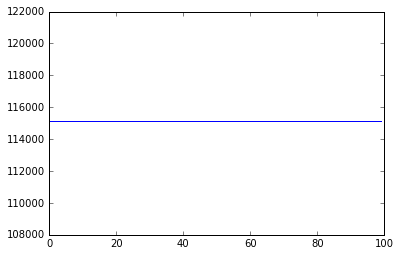

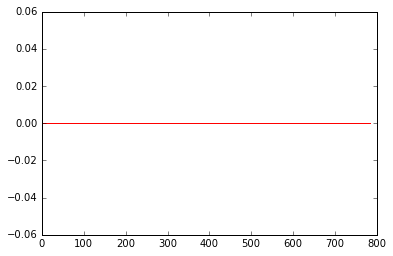

In [643]:
print "Accuracy on Training Set is {}%".format(compute_accuracy(model_coefficients,train_vec_in.T,train_label_out))
print "Accuracy on Test Set is {}%".format(compute_accuracy(model_coefficients,test_features.T,test_labels))
print "Accuracy on Validation Set is {}%".format(compute_accuracy(model_coefficients,valid_features.T,valid_labels))
plt.plot(cost)
plt.show()

plt.plot(model_coefficients.T)
plt.show()

In [423]:
## We will compute the accuracy over different values of lamda and see which maximizes the accuracy over validation set.
def cross_validation(train_features,train_labels,valid_features,valid_labels,lamda,step_size,max_iter=100):
    classes = set(train_labels)
    init_coefficients = np.zeros(shape=(len(classes),np.shape(train_vec_in)[1]))
    coefficients,_ = softmax_regression(init_coefficients,train_features,train_labels,classes,step_size,lamda,max_iter)
    valid_set_accuracy = compute_accuracy(coefficients,valid_features.T,valid_labels)
    print "accuracy for lamda {} is {}".format(lamda,valid_set_accuracy)
    return valid_set_accuracy

### Hyperparameter tuning

In [420]:
lamda = np.logspace(1, 7, num=13)
accuracy = []
step_size = 1e-5
for item in lamda:
    accuracy.append(cross_validation(train_vec_in,train_label_out,valid_features,valid_labels,item,step_size))
    
print accuracy

accuracy for lamda 10.0 is 90.39
accuracy for lamda 31.6227766017 is 90.36
accuracy for lamda 100.0 is 90.19
accuracy for lamda 316.227766017 is 89.58
accuracy for lamda 1000.0 is 87.95
accuracy for lamda 3162.27766017 is 80.93
accuracy for lamda 10000.0 is 52.73
accuracy for lamda 31622.7766017 is 10.09
accuracy for lamda 100000.0 is 1.17
accuracy for lamda 316227.766017 is 0.33
accuracy for lamda 1000000.0 is 0.32
accuracy for lamda 3162277.66017 is 0.33
accuracy for lamda 10000000.0 is 0.33
[array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), array([ True,  True,  True, ...,  True,  True,  True], dtype=bool), array([ True,  True,  Tr

In [460]:
def k_cross_validation(train_dataset,lamda,step_size,k=10,max_iter=100):
    ''' Performing k-fold cross validation. Before perfoming cross validation we will shuffle the datasets '''
    np.random.shuffle(train_dataset)
    print train_dataset
    #for i in range(k):
    n = np.shape(train_dataset)[0]
    i=0
    start = n*i/k
    end = n*(i+1)/k
    print start, end
    valid_set = train_dataset[start:end,:]
    train_data = np.concatenate((train_dataset[0:start,:],train_dataset[end:,:]),axis=0)
    print train_data

In [463]:
x = np.arange(21).reshape(7,3)
k_cross_validation(x,1,1,3,1)

[[12 13 14]
 [ 6  7  8]
 [ 0  1  2]
 [ 9 10 11]
 [18 19 20]
 [ 3  4  5]
 [15 16 17]]
0 2
[[ 0  1  2]
 [ 9 10 11]
 [18 19 20]
 [ 3  4  5]
 [15 16 17]]


In [387]:
import scipy

def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

def getProbsAndPreds(someX):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

def oneHotIt(Y):
    m = Y.shape[0]
    #Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX

def getLoss(w,x,y,lam):
    m = x.shape[0] #First we get the number of training examples
    y_mat = oneHotIt(y) #Next we convert the integer class coding into a one-hot representation
    scores = np.dot(x,w) #Then we compute raw class scores given our input and current weights
    prob = softmax(scores) #Next we perform a softmax on these scores to get their probabilities    
    loss = (-1 / m) * np.sum(y_mat * np.log(prob)) + (lam/2)*np.sum(w*w) #We then find the loss of the probabilities
    grad = (-1 / m) * np.dot(x.T,(y_mat - prob)) + lam*w #And compute the gradient for that loss
    return loss,grad,prob

w = np.zeros([np.shape(train_vec_in)[1],len(set(train_label_out))])
lam = 1
iterations = 100
learningRate = 1e-5
losses = []
for i in range(0,iterations):
    loss,grad,prob = getLoss(w,train_vec_in,train_label_out,1)
    losses.append(loss)
    w = w - (learningRate * grad)
#print grad
#print w
print loss

20125.5856655


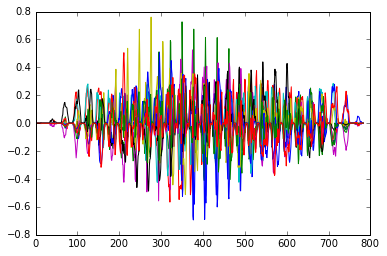

In [237]:
plt.plot(w)

In [388]:
prediction = np.argmax(np.dot(w.T,train_vec_in.T),axis=0)
print prediction
accuracy = (prediction==train_label_out)
print np.sum(accuracy,dtype='float32')/50000

[3 0 4 ..., 8 4 8]
0.89214


In [389]:
test_prediction = np.transpose(np.dot(w.T,test_features.T))
test_accuracy = (np.argmax(test_prediction,axis=1) == test_labels)
print np.sum(test_accuracy,dtype='float32')/10000
#print np.argmax(np.dot(w.T,test_features[2]))

0.9009


In [611]:
x = np.array([[1,2,3],[2,4,5],[3,6,7],[3,6,8],[7,8,9]])
print np.mean(x,axis=0)
print np.std(x,axis=0)
print (x-np.mean(x,axis=0))/np.std(x,axis=0)

[ 3.2  5.2  6.4]
[ 2.03960781  2.03960781  2.15406592]
[[-1.07863874 -1.56892908 -1.57841037]
 [-0.58834841 -0.58834841 -0.64993368]
 [-0.09805807  0.39223227  0.27854301]
 [-0.09805807  0.39223227  0.74278135]
 [ 1.86310328  1.37281295  1.2070197 ]]


In [601]:
np.std(x,axis=1)

array([ 0.81649658,  1.24721913,  1.69967317,  2.05480467,  0.81649658])

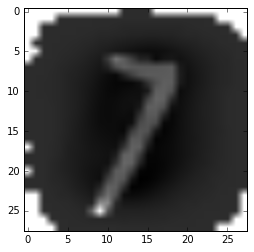

In [612]:
train_scaled = (train_vec_in-np.mean(train_vec_in,axis=0))/np.std(train_vec_in,axis=0)
plt.imshow(np.reshape(train_scaled[0],(28,28)),cmap='gray')

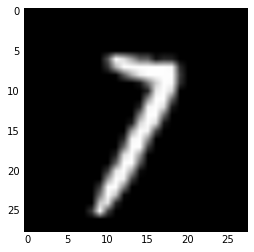

In [613]:
plt.imshow(np.reshape(train_vec_in[0],(28,28)),cmap='gray')

In [11]:
x = np.array([[4,1,-1,2,3,4,-2], [-1,23,-34,1,32,4,6]])
print np.maximum(0,x)

[[ 4  1  0  2  3  4  0]
 [ 0 23  0  1 32  4  6]]


In [12]:
np.transpose(x)

array([[  4,  -1],
       [  1,  23],
       [ -1, -34],
       [  2,   1],
       [  3,  32],
       [  4,   4],
       [ -2,   6]])

In [13]:
x.T

array([[  4,  -1],
       [  1,  23],
       [ -1, -34],
       [  2,   1],
       [  3,  32],
       [  4,   4],
       [ -2,   6]])